# How large can my memory be while still maintaining less control resources than a memory-less system

In [50]:
import numpy as np 
import matplotlib.pyplot as plt


# RAM Surface Code Scaling with coherence time 
Consider gate time, and mode coherence

error correction cycle length \(t_{log}\). main error
error on physical qubit $$p = \frac{t_{log}}{T_{\text{coh},qub}}$$
error on memory $$p_{mem,idle} =  \frac{(N-1) *( t_{log} + 2t_{swap})}{T_{\text{coh},mem}}  $$
error on memory swap $$p_{mem, gate} = t_{swap}*(\frac{1}{T_{\text{coh}, mem}} + \frac{1}{T_{\text{coh}, qub}})$$
$$$$

Plots 
x axis: t1 qub
y axis : t1 mem 
z axis: lower bound on number of raqm/ upper 
two of these plots 

at error rate 1e-10

## Remember fundamental equations 
### memory less system 
$$\varepsilon = \left(\frac{p  }{p_{\text{threshold}}}\right)^{D}$$
### memory full system 
$$\varepsilon' = \left(\frac{p + p_{mem}}{p_{\text{threshold}}}\right)^{D'}$$

### Comparison of resources 
c = 3 (z + x + ancilla control)
$$(c+1)D'^2 <cND^2$$

In [164]:
def p_qubit(t_log_cycle, T_coh_qubit):
    '''
    $$p = \frac{t_{log}}{T_{\text{coh},qub}}$$
    '''
    return t_log_cycle / T_coh_qubit

def p_swap(t_swap, T_coh_cav, T_coh_qubit):
    '''
    2 total swaps, half in qubit, half in cavity
    $$p_{swap} = \frac{t_{swap}}{T_{\text{coh},cav}} + \frac{t_{swap}}{T_{\text{coh},qub}}$$
    '''
    return t_swap / T_coh_cav + t_swap / T_coh_qubit

def p_mem_idle(t_log_cycle, t_swap, N, T_coh_cav):
    '''
    Time spent idle in memory is (N-1) * (t_log_cycle + 2*t_swap) / T_coh_cav
    # '''
    # print(f"Memory idle time: {(N-1) * (t_log_cycle + 2*t_swap)}")
    return (N-1) * (t_log_cycle + 2*t_swap) / T_coh_cav

def find_d_prime(vareps, t_log_cycle, t_swap, N, T_coh_cav, T_coh_qubit, p_threshold=0.01):
    # $$\varepsilon' = \left(\frac{p + p_{mem}}{p_{\text{threshold}}}\right)^{D'}$$
    
    # print(f"p_qubit: {p_qubit(t_log_cycle, T_coh_qubit)}")
    # print(f"p_mem_idle: {p_mem_idle(t_log_cycle, t_swap, N, T_coh_cav)}")
    # print(f"p_swap: {p_swap(t_swap, T_coh_cav, T_coh_qubit)}")
    p = p_qubit(t_log_cycle, T_coh_qubit) + p_mem_idle(t_log_cycle, t_swap, N, T_coh_cav) + p_swap(t_swap, T_coh_cav, T_coh_qubit)
    base = p/p_threshold

    if np.round(base,3)>=1: 
        return -1

    return np.log(vareps) / np.log(base)

def find_d(vareps, t_log_cycle, T_coh_qubit, p_threshold=0.01):
    
    # \varepsilon = \left(\frac{p}{p_{\text{threshold}}}\right)^{D}
    
    p = p_qubit(t_log_cycle, T_coh_qubit)
    base = p/p_threshold
    # print(f"p: {p}, base: {base}")

    if np.round(base,3)>=1: 
        return -1

    return np.log(vareps) / np.log(base)


# find the lowest N and highest N for which $$2D'^2 <ND^2$$
def find_N_bounds(vareps, t_log_cycle, t_swap, T_coh_cav, T_coh_qubit, p_threshold=0.01, N_min=1, N_max=500, c= 3):
    '''
    Find the lowest and highest N for which 2D'^2 < N D^2
    Returns (N_low, N_high) or (None, None) if no such N exists.
    '''
    D = find_d(vareps, t_log_cycle, T_coh_qubit, p_threshold)
    N_low, N_high = None, None
    for N in range(N_min, N_max+1):
        Dp = find_d_prime(vareps, t_log_cycle, t_swap, N, T_coh_cav, T_coh_qubit, p_threshold)
        # print(f"N={N}, D'={Dp}, D={D}, 2D'^2={2*Dp**2}, ND^2={N*(D**2)}")
        if Dp < 0 or D < 0:
            continue
        if (c+1)*Dp**2 < c*N*D**2:
            if N_low is None:
                N_low = N
            N_high = N
    return N_low, N_high

# Example usage:
vareps = 1e-10 # doesnt matter!
t_log_cycle = 2e-7 #https://arxiv.org/pdf/2408.13687v1 have 42 ns cz (check readout)
t_swap = 5e-7 #https://arxiv.org/abs/2303.00959 have 100 ns swaps
T_coh_cav = 20e-3
T_coh_qubit = 5e-4

# debug d' 
# Dp = find_d_prime(vareps, t_log_cycle, t_swap, 10, T_coh_cav, T_coh_qubit)
# print(f"D': {Dp}")

N_low, N_high = find_N_bounds(vareps, t_log_cycle, t_swap, T_coh_cav, T_coh_qubit)
print(f"Lowest N: {N_low}, Highest N: {N_high}")




Lowest N: 5, Highest N: 89


In [165]:
# now we vary t_coh_qubit (x axis) and t_coh_cav (y axis) and plot N_low and N_high
T_coh_qubit_vals = np.logspace(-4, -1, 100)
T_coh_cav_vals = np.logspace(-3, -1, 100)

N_low_vals = []
N_high_vals = []

for T_coh_qubit in T_coh_qubit_vals:
    for T_coh_cav in T_coh_cav_vals:
        N_low, N_high = find_N_bounds(vareps, t_log_cycle, t_swap, T_coh_cav, T_coh_qubit)
        if N_low is None:
            N_low = np.nan
        if N_high is None:
            N_high = np.nan
        N_low_vals.append(N_low)
        N_high_vals.append(N_high)



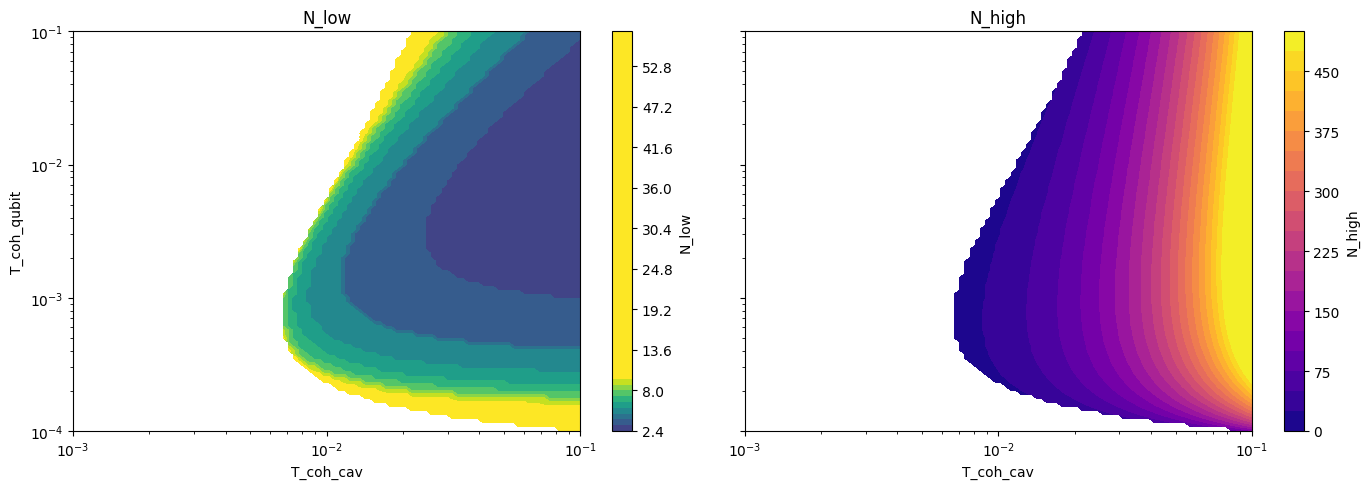

In [166]:
# Reshape results for plotting
N_low_vals = np.array(N_low_vals).reshape(len(T_coh_qubit_vals), len(T_coh_cav_vals))
N_high_vals = np.array(N_high_vals).reshape(len(T_coh_qubit_vals), len(T_coh_cav_vals))


# Plot contours of N_low and N_high
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# N_low contour
c0 = axs[0].contourf(T_coh_cav_vals, T_coh_qubit_vals, N_low_vals, levels=80, cmap='viridis')
axs[0].set_title('N_low')
axs[0].set_xlabel('T_coh_cav')
axs[0].set_ylabel('T_coh_qubit')
axs[0].set_xscale('log')
axs[0].set_yscale('log')
fig.colorbar(c0, ax=axs[0], label='N_low')
# recale colorbar to be max of 5
c0.set_clim(1, 10)

# N_high contour
c1 = axs[1].contourf(T_coh_cav_vals, T_coh_qubit_vals, N_high_vals, levels=20, cmap='plasma')
axs[1].set_title('N_high')
axs[1].set_xlabel('T_coh_cav')
axs[1].set_xscale('log')
axs[1].set_yscale('log')
fig.colorbar(c1, ax=axs[1], label='N_high')

plt.tight_layout()
plt.show()




In [124]:
N_low_vals

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., 3, 3, 3],
       [nan, nan, nan, ..., 3, 3, 3],
       [nan, nan, nan, ..., 3, 3, 3]], dtype=object)

In [121]:
np.min(N_low_vals)

nan

In [72]:
T_coh_cav_vals

array([1.00000000e-03, 1.09749877e-03, 1.20450354e-03, 1.32194115e-03,
       1.45082878e-03, 1.59228279e-03, 1.74752840e-03, 1.91791026e-03,
       2.10490414e-03, 2.31012970e-03, 2.53536449e-03, 2.78255940e-03,
       3.05385551e-03, 3.35160265e-03, 3.67837977e-03, 4.03701726e-03,
       4.43062146e-03, 4.86260158e-03, 5.33669923e-03, 5.85702082e-03,
       6.42807312e-03, 7.05480231e-03, 7.74263683e-03, 8.49753436e-03,
       9.32603347e-03, 1.02353102e-02, 1.12332403e-02, 1.23284674e-02,
       1.35304777e-02, 1.48496826e-02, 1.62975083e-02, 1.78864953e-02,
       1.96304065e-02, 2.15443469e-02, 2.36448941e-02, 2.59502421e-02,
       2.84803587e-02, 3.12571585e-02, 3.43046929e-02, 3.76493581e-02,
       4.13201240e-02, 4.53487851e-02, 4.97702356e-02, 5.46227722e-02,
       5.99484250e-02, 6.57933225e-02, 7.22080902e-02, 7.92482898e-02,
       8.69749003e-02, 9.54548457e-02, 1.04761575e-01, 1.14975700e-01,
       1.26185688e-01, 1.38488637e-01, 1.51991108e-01, 1.66810054e-01,
      

## RAM surface code scaling
$$\varepsilon' = \left(\frac{p + 2Np_{\text{swap}}/8}{p_{\text{threshold}}}\right)^{D'}$$

Control Resources per logical qubit $r = 2D'^2 /N$



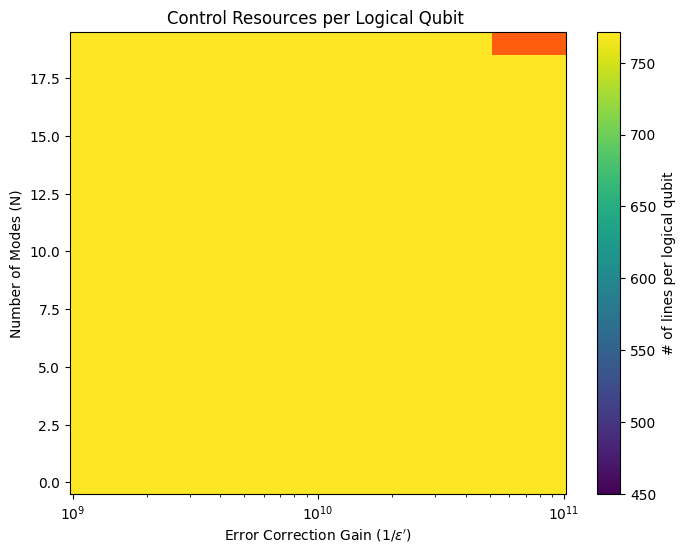

In [52]:
def D_prime(vareps_prime, N, p_swap = 0.001, p_threshold = 0.01, p = 0.005):    
    # Solve for D' in terms of vareps_prime and N
    # vareps_prime = ((p + 2*N*p_swap/8) / p_threshold) ** D'
    # Take log on both sides:
    # log(vareps_prime) = D' * log((p + 2*N*p_swap/8) / p_threshold)
    # D' = log(vareps_prime) / log((p + 2*N*p_swap/8) / p_threshold)
    # p = 0.01
    # p_swap = 0.005
    # p_threshold = 0.1
    base = (p + 2 * N * p_swap / 8) / p_threshold

    if base>1: 
        return 100000

    return np.log(vareps_prime) / np.log(base)



def plot_control_resources(vareps_prime_vals, N_vals, D_prime_func):
    import matplotlib.colors as mcolors

    # Compute Z as before
    X, Y = np.meshgrid(1/np.array(vareps_prime_vals), N_vals)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Dp = D_prime_func(1/X[i, j], Y[i, j])
            if Y[i, j] == 0:
                Z[i, j] = 2 * Dp**2
            else:
                Z[i, j] = 2 * Dp**2 / Y[i, j]

    # Create a masked array for values > 500
    Z_masked = np.ma.masked_where(Z <= 100000, Z)

    plt.figure(figsize=(8, 6))
    c = plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis', norm=mcolors.Normalize(vmin=Z.min(), vmax=500))
    plt.pcolormesh(X, Y, Z_masked, shading='auto', cmap=mcolors.ListedColormap(['red']), alpha=0.6)
    plt.xscale('log')
    plt.xlabel("Error Correction Gain ($1/\\varepsilon'$)")
    plt.ylabel("Number of Modes (N)")
    plt.title("Control Resources per Logical Qubit ")
    plt.colorbar(c, label="# of lines per logical qubit")
    plt.show()

N_vals = np.arange(0, 20,1)
vareps_prime_vals = np.logspace(-11, -9, 100)
plot_control_resources(vareps_prime_vals, N_vals, D_prime)
# plt.xscale('log')

In [53]:
 

def D_prime(vareps_prime, N, p_swap = 0.001, p_threshold = 0.01, p = 0.005):    
    # Solve for D' in terms of vareps_prime and N
    # vareps_prime = ((p + 2*N*p_swap/8) / p_threshold) ** D'
    # Take log on both sides:
    # log(vareps_prime) = D' * log((p + 2*N*p_swap/8) / p_threshold)
    # D' = log(vareps_prime) / log((p + 2*N*p_swap/8) / p_threshold)
    # p = 0.01
    # p_swap = 0.005
    # p_threshold = 0.1
    base = (p + 2 * N * p_swap / 8) / p_threshold

    if base>1: 
        return 500

    return np.log(vareps_prime) / np.log(base)



def plot_control_resources(vareps_prime_vals, N_vals, D_prime_func):
    import matplotlib.colors as mcolors

    # Compute Z as before
    X, Y = np.meshgrid(1/np.array(vareps_prime_vals), N_vals)
    Z = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            Dp = D_prime_func(1/X[i, j], Y[i, j])
            if Y[i, j] == 0:
                Z[i, j] = 2 * Dp**2
            else:
                Z[i, j] = 2 * Dp**2 / Y[i, j]

    # Create a masked array for values > 500
    Z_masked = np.ma.masked_where(Z <= 500, Z)

    plt.figure(figsize=(8, 6))
    c = plt.pcolormesh(X, Y, Z, shading='auto', cmap='viridis', norm=mcolors.Normalize(vmin=Z.min(), vmax=500))
    plt.pcolormesh(X, Y, Z_masked, shading='auto', cmap=mcolors.ListedColormap(['red']), alpha=0.6)
    plt.xscale('log')
    plt.xlabel("Error Correction Gain ($1/\\varepsilon'$)")
    plt.ylabel("Number of Modes (N)")
    plt.title("Control Resources per Logical Qubit ")
    plt.colorbar(c, label="# of lines per logical qubit")
    plt.show()


# I  want a table of color plots  with x axis being p swap and y axis being p 
# us the functions below
# Define ranges for p_swap and p
p_swap_vals = np.linspace(0.0001, 0.01, 4)
p_vals = np.linspace(0.001, 0.02, 4)

fig, axes = plt.subplots(len(p_vals), len(p_swap_vals), figsize=(16, 12), sharex=True, sharey=True)

for i, p in enumerate(p_vals):
    for j, p_swap in enumerate(p_swap_vals):
        def D_prime_custom(vareps_prime, N):
            base = (p + 2 * N * p_swap / 8) / 0.01  # p_threshold fixed at 0.01
            if base > 1:
                return 500
            return np.log(vareps_prime) / np.log(base)
        
        X, Y = np.meshgrid(1/np.array(vareps_prime_vals), N_vals)
        Z = np.zeros_like(X)
        for m in range(X.shape[0]):
            for n in range(X.shape[1]):
                Dp = D_prime_custom(1/X[m, n], Y[m, n])
                if Y[m, n] == 0:
                    Z[m, n] = 2 * Dp**2
                else:
                    Z[m, n] = 2 * Dp**2 / Y[m, n]
        Z_masked = np.ma.masked_where(Z <= 500, Z)
        ax = axes[i, j]
        c = ax.pcolormesh(X, Y, Z, shading='auto', cmap='viridis', vmin=Z.min(), vmax=500)
        ax.pcolormesh(X, Y, Z_masked, shading='auto', cmap=plt.cm.Reds, alpha=0.6)
        ax.set_xscale('log')
        if i == len(p_vals) - 1:
            ax.set_xlabel("$1/\\varepsilon'$")
        if j == 0:
            ax.set_ylabel("N")
        ax.set_title(f"p={p:.3g}, p_swap={p_swap:.4f}")

fig.suptitle("Control Resources per Logical Qubit for varying p and p_swap", fontsize=16)
fig.tight_layout(rect=[0, 0, 1, 0.97])
fig.colorbar(c, ax=axes, orientation='vertical', label="# of lines per logical qubit")
plt.show()

# N_vals = np.arange(0, 10,1)
# vareps_prime_vals = np.logspace(-5, -1, 100)
# plot_control_resources(vareps_prime_vals, N_vals, D_prime)
# plt.xscale('log')

ValueError: minvalue must be less than or equal to maxvalue

<Figure size 1600x1200 with 17 Axes>

import numpy as n